In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
from Timer import Timer
import IPythonMagic 

import pytest
from ipytest import clean_tests, run_pytest

import pycuda.compiler as cuda_compiler
import pycuda.driver as cuda_driver
from pycuda.gpuarray import GPUArray

In [2]:
# These come from the IPythonMagic module
%setup_logging
%cuda_context_handler context

Python version 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Registering context in user workspace
Creating context
PyCUDA version 2018.1.1
CUDA version (9, 1, 0)
Driver version 10000
Using 'Tesla K80' GPU
 => compute capability: (3, 7)
 => memory: 10447 / 11441 MB available
Created context handle <46699728>
Using CUDA cache dir /home/ubuntu/jupyter_notebooks/Stefano_B/MilanoGPU2018/TMP/MilanoGPU2018/notebooks/cuda_cache


In [3]:
# We createa a HeatEquation1D class, since the kernel will be somehow more complex than before
class HeatEquation1D(object):
    """
    The class approximates the solution of the heat equation
    """
    
    # In Python all methods are static unless you start with an argument "self".
    # __init__ is the constructor
    def __init__(self, u0, kappa, dx, dt):
        # This would create a pointer. It's dangerous. Let's make a copy so we don't 
        # mess up with values out of the class
        #self.u0    = u0
        #self.kappa = kappa
        #self.dx    = dx
        #self.dt    = dt
        
        self.u0    = u0.copy()
        self.u1    = np.empty_like(self.u0) # this does not initialize. It should be fast!
        self.kappa = kappa
        self.dx    = dx
        self.dt    = dt
        self.nx    = self.u0.shape[0] - 2 # points minus the boundaries points
        
    # Create a step function that evolves the system in time
    def step(self):
        for i in range(1,self.nx+1):
            self.u1[i] = self.u0[i] + kappa*dt/(dx**2) * (self.u0[i-1] - 2.0*self.u0[i] + self.u0[i+1])
            
        self.u1[0] = self.u1[1]
        self.u1[self.nx+1] = self.u1[self.nx]
        
        # swap u1 and u0
        # after the test is complete, u0 is the most recent result
        self.u0, self.u1 = self.u1, self.u0
        
    def download(self): # we will use this functionality with the GPU
        return self.u0.copy()
        

In [22]:
# We createa a HeatEquation1D class, since the kernel will be somehow more complex than before
class HeatEquation1DGPU(object):
    """
    The class approximates the solution of the heat equation on the GPU
    """
    
    # In Python all methods are static unless you start with an argument "self".
    # __init__ is the constructor
    def __init__(self):
        pass
    
    def createKernel(self):
        src = """
        __global__ void heatEquation(float* u1, const float* u0, float kappa, float dx, float dt, int nx){
            // Note: Skip the first ghost cell (put a "+ 1")
            int i = blockIdx.x*blockDim.x + threadIdx.x + 1;
            
            if (i >= 1 && i <= nx){
                // Hey note the "2.0f"!!! without the f I'm calling for a double precision multiplication!!! EXPENSIVE!
                u1[i] = u0[i] + kappa*dt/(dx*dx)*(u0[i-1] - 2.0f*u0[i] + u0[i+1]); 
            }
            
            // This handles the left boundary
            if (i == 1) {
                u1[0] = u0[i] + kappa*dt/(dx*dx)*(u0[i-1] - 2.0f*u0[i] + u0[i+1]); 
            }
            
            // This handles the right boundary
            if (i == nx) {
                u1[nx+1] = u0[i] + kappa*dt/(dx*dx)*(u0[i-1] - 2.0f*u0[i] + u0[i+1]); 
            }
        }
        
        __device__ int computePi() {
            return 22.0/7.0;
        }
        """
    
        # Now let's compile the source code, "src"
        self.module = cuda_compiler.SourceModule(src,options=['--use_fast_math'])
        self.kernel = self.module.get_function("heatEquation")
        # we have to prepare a call... since we want to run it fast (!)
        self.kernel.prepare("PPfffi") # pass the types. 
    
    # We prefer to move initialization out of the constructor.. just because of errors..
    def initialize(self, u0, kappa, dx, dt):
        self.kappa = np.float32(kappa)
        self.dx    = np.float32(dx)
        self.dt    = np.float32(dt)
        self.nx    = np.int32(u0.shape[0] - 2) # points minus the boundaries points
        
        # Allocate data on the GPU and upload
        assert u0.dtype == np.float32, "u0 MUST be float"
        self.u0_g = GPUArray(u0.shape, u0.dtype)
        self.u1_g = GPUArray(u0.shape, u0.dtype)
        self.u0_g.set(u0)
        
        # Create the kernel
        self.createKernel()
        
        num_threads = 128
        self.block_size = (num_threads, 1, 1)
        self.grid_size = (int(np.ceil(self.u0_g.shape[0]/num_threads)), 1, 1)
        self.stream = cuda_driver.Stream()
        
        print(self.block_size)
        print(self.grid_size)
        print(self.u0_g.shape)
        
    # Create a step function that evolves the system in time
    def step(self):
        
        # Step: we wish to run using our kernel
        self.kernel.prepared_async_call(self.grid_size, self.block_size, self.stream, \
                                        self.u1_g.gpudata, self.u0_g.gpudata, self.kappa, self.dx, self.dt, self.nx)

        # swap u1 and u0
        # after the test is complete, u0 is the most recent result
        # THIS DOES NOT MOVE ANY DATA!!! JUST SWAPS THE POINTERS!!!!
        self.u0_g, self.u1_g = self.u1_g, self.u0_g

        #for i in range(1,self.nx+1):
        #    self.u1[i] = self.u0[i] + kappa*dt/(dx**2) * (self.u0[i-1] - 2.0*self.u0[i] + self.u0[i+1])
        #    
        #self.u1[0] = self.u1[1]
        #self.u1[self.nx+1] = self.u1[self.nx]
        
        
    def download(self): # we will use this functionality with the GPU
        u0 = np.empty(self.u0_g.shape, self.u0_g.dtype)
        self.u0_g.get(u0)
        return u0

In [23]:
u0    = np.zeros(5, dtype=np.float32)
u0[2] = 1.0

kappa = 1.0
dx    = 1.0
CFL   = 0.4
dt    = CFL*dx**2/(2*kappa) # careful: "/" in python2 does integer division if it can

gpu_simulator = HeatEquation1DGPU()        
gpu_simulator.initialize(u0, kappa, dx, dt)

gpu_simulator.step()
result = gpu_simulator.download()
print(result)
#fig = plt.figure()
#for i in range(10):
#    simulator.step()
#    result = simulator.download()
#    print(result)
#    plt.plot(u0)
#    plt.show()
    

(128, 1, 1)
(1, 1, 1)
(5,)
[0.2 0.2 0.6 0.2 0.2]


[0.  0.  0.2 0.6 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
[0.04 0.04 0.24 0.44 0.24 0.04 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.  ]


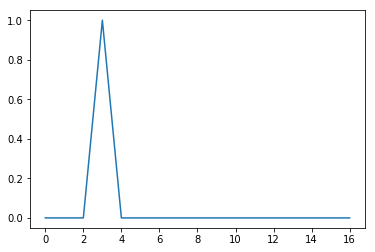

[0.08  0.08  0.24  0.36  0.24  0.072 0.008 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.   ]


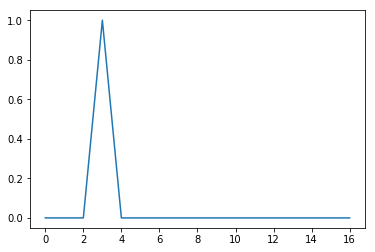

[0.112  0.112  0.232  0.312  0.2304 0.0928 0.0192 0.0016 0.     0.
 0.     0.     0.     0.     0.     0.     0.    ]


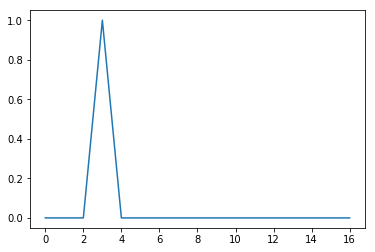

[0.136   0.136   0.224   0.27968 0.2192  0.1056  0.0304  0.0048  0.00032
 0.      0.      0.      0.      0.      0.      0.      0.     ]


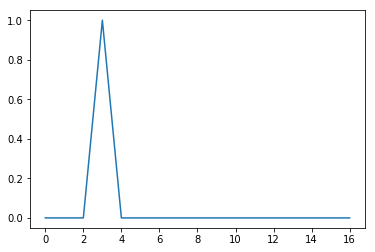

[1.53600e-01 1.53600e-01 2.17536e-01 2.56448e-01 2.08576e-01 1.13280e-01
 4.03200e-02 9.02400e-03 1.15200e-03 6.40000e-05 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]


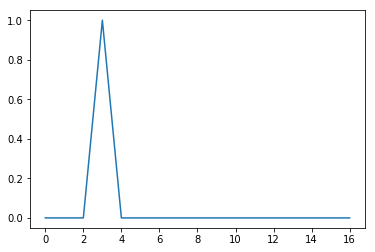

[1.663872e-01 1.663872e-01 2.125312e-01 2.390912e-01 1.990912e-01
 1.177472e-01 4.865280e-02 1.370880e-02 2.508800e-03 2.688000e-04
 1.280000e-05 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00]


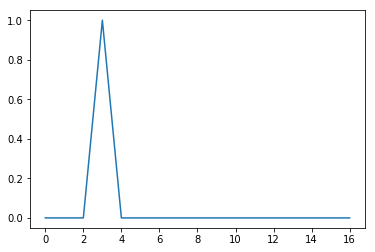

[1.7561600e-01 1.7561600e-01 2.0861440e-01 2.2577920e-01 1.9082240e-01
 1.2019712e-01 5.5482880e-02 1.8457600e-02 4.3008000e-03 6.6560000e-04
 6.1440000e-05 2.5600000e-06 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00]


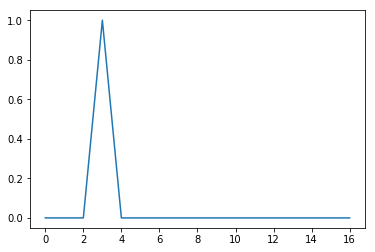

[1.82215680e-01 1.82215680e-01 2.05447680e-01 2.15354880e-01
 1.83688704e-01 1.21379328e-01 6.10206720e-02 2.30312960e-02
 6.40512000e-03 1.27180800e-03 1.70496000e-04 1.38240000e-05
 5.12000000e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


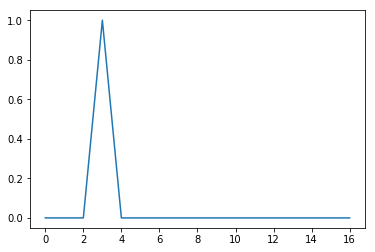

[1.86862080e-01 1.86862080e-01 2.02782720e-01 2.07040205e-01
 1.77560064e-01 1.21769472e-01 6.54945280e-02 2.73039360e-02
 8.70369280e-03 2.07820800e-03 3.59424000e-04 4.24960000e-05
 3.07200000e-06 1.02400000e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


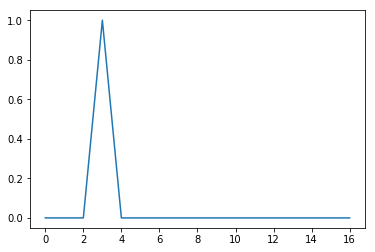

[1.90046208e-01 1.90046208e-01 2.00450089e-01 2.00292680e-01
 1.72297974e-01 1.21672602e-01 6.91113984e-02 3.12220058e-02
 1.10986445e-02 3.05954816e-03 6.39795200e-04 9.79968000e-05
 1.03628800e-05 6.75840000e-07 2.04800000e-08 0.00000000e+00
 0.00000000e+00]


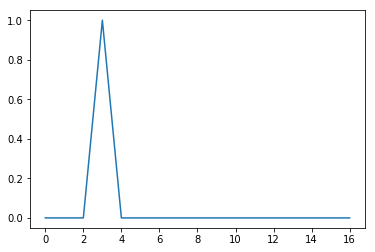

In [24]:
u0    = np.zeros(17)
u0[3] = 1.0

kappa = 1.0
dx    = 1.0
CFL   = 0.4
dt    = CFL*dx**2/(2*kappa) # careful: "/" in python2 does integer division if it can

simulator = HeatEquation1D(u0, kappa, dx, dt)        
simulator.step()

result = simulator.download()
print(result)

fig = plt.figure()
for i in range(10):
    simulator.step()
    result = simulator.download()
    print(result)
    plt.plot(u0)
    plt.show()
    

In [12]:
clean_tests()

def test_HeatEquation1D():
    u0    = np.zeros(15)
    kappa = 1.0
    dx    = 1.0
    CFL   = 0.4
    dt    = CFL*dx**2/(2*kappa) # careful: "/" in python2 does integer division if it can

    simulator = HeatEquation1D(u0, kappa, dx, dt)
    
    assert np.all(u0 == simulator.u0)
    assert simulator.u0.shape == simulator.u1.shape
    assert kappa == simulator.kappa
    assert dx == simulator.dx
    assert dt == simulator.dt

    u0    = np.zeros(15)
    u0[3] = 1.0
    kappa = 1.0
    dx    = 1.0
    CFL   = 0.4
    dt    = CFL*dx**2/(2*kappa) # careful: "/" in python2 does integer division if it can

    simulator = HeatEquation1D(u0, kappa, dx, dt)
    
    for i in range(10):
        simulator.step()
        result = simulator.download()
        print(result)
        assert np.sum(result[1:-1]) == pytest.approx(1.0)
        assert result[0] == result[1]
        assert result[u0.shape[0]-1] == result[u0.shape[0]-2]
        
        
run_pytest(filename='HeatEquation1D_STEFEDE.ipynb', pytest_options=['-vvv'])

============================= test session starts ==============================
platform linux -- Python 3.6.6, pytest-3.8.2, py-1.6.0, pluggy-0.7.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /home/ubuntu/jupyter_notebooks/Stefano_B/MilanoGPU2018/TMP/MilanoGPU2018/notebooks, inifile:
collecting ... collected 1 item

HeatEquation1D_STEFEDE.py::test_HeatEquation1D <- <ipython-input-12-00182be1a748> PASSED [100%]

=========================== 1 passed in 0.03 seconds ===========================


0